# Evolver Loop 1 Analysis

## Objectives
1. Analyze per-N score breakdown to identify optimization targets
2. Verify the baseline submission has no overlaps
3. Understand the gap to target (68.92)

In [1]:
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree
import matplotlib.pyplot as plt

getcontext().prec = 30
scale_factor = 1

print('Libraries loaded')

Libraries loaded


In [2]:
# Christmas Tree class
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

print('ChristmasTree class defined')

ChristmasTree class defined


In [3]:
# Helper functions
def load_configuration_from_df(n, df):
    group_data = df[df['id'].str.startswith(f'{n:03d}_')]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row['x'])[1:]  # Remove 's' prefix
        y = str(row['y'])[1:]
        deg = str(row['deg'])[1:]
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
    return trees

def get_score(trees, n):
    if not trees:
        return 0.0
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side_length = max(max_x - min_x, max_y - min_y)
    return side_length**2 / n

def has_overlap(trees):
    if len(trees) <= 1:
        return False
    polygons = [t.polygon for t in trees]
    tree_index = STRtree(polygons)
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx == i:
                continue
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                return True
    return False

print('Helper functions defined')

Helper functions defined


In [4]:
# Load the baseline submission
baseline_path = '/home/code/preoptimized_submission.csv'
df = pd.read_csv(baseline_path)
print(f'Loaded {len(df)} rows from baseline submission')

Loaded 20100 rows from baseline submission


In [5]:
# Compute per-N score breakdown
scores = []
overlaps = []

for n in range(1, 201):
    trees = load_configuration_from_df(n, df)
    score = get_score(trees, n)
    has_ovl = has_overlap(trees)
    scores.append({'N': n, 'score': score, 'has_overlap': has_ovl})
    if has_ovl:
        overlaps.append(n)

scores_df = pd.DataFrame(scores)
print(f'Total score: {scores_df["score"].sum():.6f}')
print(f'Configurations with overlaps: {overlaps if overlaps else "None"}')
print(f'Target: 68.922808')
print(f'Gap: {scores_df["score"].sum() - 68.922808:.6f}')

Total score: 70.743774
Configurations with overlaps: None
Target: 68.922808
Gap: 1.820966


In [6]:
# Identify worst-performing N values (highest score contribution)
scores_df_sorted = scores_df.sort_values('score', ascending=False)
print('Top 20 worst-performing N values (highest score contribution):')
print(scores_df_sorted.head(20).to_string(index=False))

Top 20 worst-performing N values (highest score contribution):
 N    score  has_overlap
 1 0.661250        False
 2 0.450779        False
 3 0.434745        False
 5 0.416850        False
 4 0.416545        False
 7 0.399897        False
 6 0.399610        False
 9 0.387415        False
 8 0.385407        False
14 0.380398        False
15 0.379203        False
10 0.376630        False
21 0.376451        False
20 0.376057        False
11 0.375736        False
22 0.375258        False
16 0.374128        False
26 0.373997        False
12 0.372724        False
13 0.372323        False


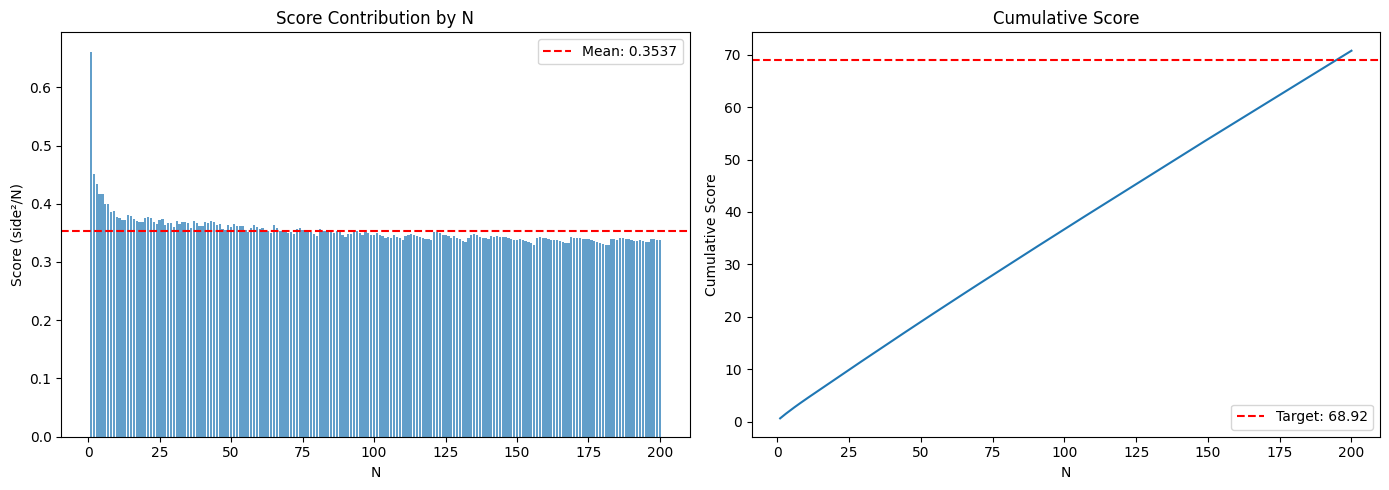

In [7]:
# Plot score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score by N
axes[0].bar(scores_df['N'], scores_df['score'], alpha=0.7)
axes[0].set_xlabel('N')
axes[0].set_ylabel('Score (side²/N)')
axes[0].set_title('Score Contribution by N')
axes[0].axhline(y=scores_df['score'].mean(), color='r', linestyle='--', label=f'Mean: {scores_df["score"].mean():.4f}')
axes[0].legend()

# Cumulative score
scores_df['cumulative'] = scores_df['score'].cumsum()
axes[1].plot(scores_df['N'], scores_df['cumulative'])
axes[1].set_xlabel('N')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative Score')
axes[1].axhline(y=68.922808, color='r', linestyle='--', label='Target: 68.92')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

In [8]:
# Analyze score statistics
print('Score Statistics:')
print(f'  Mean: {scores_df["score"].mean():.6f}')
print(f'  Std: {scores_df["score"].std():.6f}')
print(f'  Min: {scores_df["score"].min():.6f} (N={scores_df.loc[scores_df["score"].idxmin(), "N"]})')
print(f'  Max: {scores_df["score"].max():.6f} (N={scores_df.loc[scores_df["score"].idxmax(), "N"]})')

# How much improvement needed per N on average?
target = 68.922808
current = scores_df['score'].sum()
gap = current - target
print(f'\nTo reach target:')
print(f'  Need to reduce total by: {gap:.6f}')
print(f'  Average reduction per N: {gap/200:.6f}')
print(f'  Percentage reduction: {100*gap/current:.2f}%')

Score Statistics:
  Mean: 0.353719
  Std: 0.028060
  Min: 0.329960 (N=181)
  Max: 0.661250 (N=1)

To reach target:
  Need to reduce total by: 1.820966
  Average reduction per N: 0.009105
  Percentage reduction: 2.57%
